In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import proplot as pro
from scipy.interpolate import interp1d

In [3]:
rootdir = Path("/home/scexao/mlucas/20231117_vampires_iwa")
datadir = rootdir / "data"
figdir = rootdir / "figures"
figdir.mkdir(parents=True, exist_ok=True)

In [4]:
keys = ("clc2", "clc3", "clc5", "clc7", "dgvvc")
tables = {k: pd.read_csv(datadir / f"{k}.csv", index_col=0) for k in keys}

In [5]:
plate_scale = 1.8e3 # mas / mm
_tables = {}
for key, table in tables.items():
    table["x_mas"] = table["x"] * plate_scale
    table["y_mas"] = table["y"] * plate_scale
    table.sort_values(["x_mas", "y_mas"], inplace=True)
    _tables[key] = table
tables = _tables.copy()

In [6]:
tables["clc2"]

,x,y,total,totalerr,x_mas,y_mas
0,-0.200,-0.002,1.719351e+06,216.288142,-360.0,-3.6
1,-0.200,0.000,1.720454e+06,216.080171,-360.0,0.0
2,-0.200,0.002,1.720729e+06,215.622171,-360.0,3.6
5,-0.198,-0.002,1.721654e+06,211.584410,-356.4,-3.6
4,-0.198,0.000,1.722611e+06,216.930409,-356.4,0.0
...,...,...,...,...,...,...
598,0.198,0.000,1.729479e+06,215.563632,356.4,0.0
597,0.198,0.002,1.727197e+06,214.508926,356.4,3.6
600,0.200,-0.002,1.732154e+06,215.425392,360.0,-3.6
601,0.200,0.000,1.731371e+06,216.621709,360.0,0.0


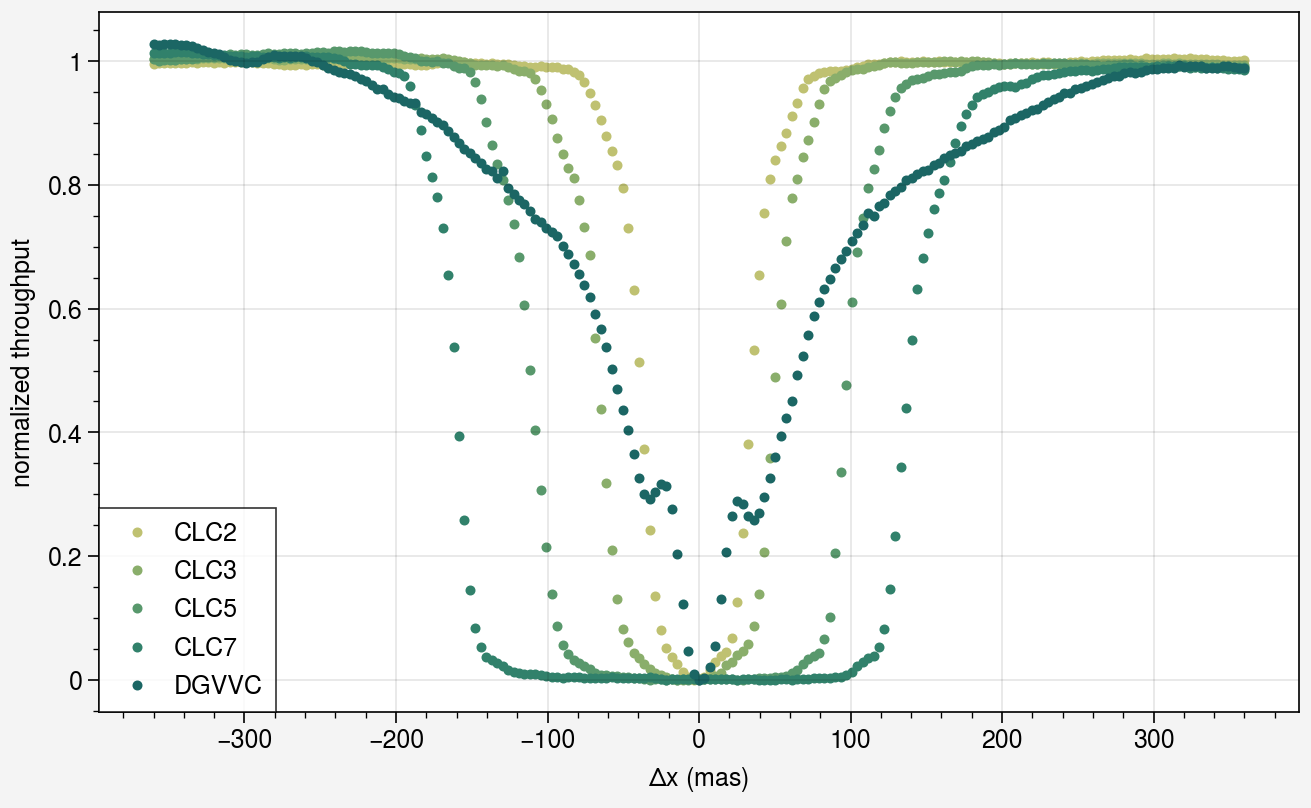

In [7]:
fig, axes = pro.subplots(refwidth="6in", refheight="3.5in")

radii = {}
fluxes = {}

cycle = pro.Colormap("boreal")(np.linspace(0.3, 0.7, len(tables)))
for i, (key, table) in enumerate(tables.items()):

    row = table.groupby("x_mas").apply(lambda r: r["total"].min())

    max_val = np.mean(row[np.abs(row.index) > 270])
    norm_data = (row - row.min()) / (max_val - row.min())

    radii[key] = row.index
    fluxes[key] = norm_data.values
    axes[0].scatter(row.index, norm_data.values, m=".", label=key.upper(), c=cycle[i])

axes[0].legend(ncols=1)
axes.format(
    xlabel=r"$\Delta$x (mas)",
    ylabel="normalized throughput"
)

In [8]:
iwas = {}
centers = {}
for key in fluxes:
    m = radii[key] >= 0
    
    itp = interp1d(fluxes[key][m], radii[key][m], kind="cubic")
    itp_neg = interp1d(fluxes[key][~m], np.abs(radii[key][~m]), kind="cubic")
    iwa = itp(0.5)
    iwa_neg = itp_neg(0.5)

    pos_x = np.where(fluxes[key][m] >= 0.15)[0][0]
    neg_x = np.where(fluxes[key][~m][::-1] >= 0.15)[0][0]
    centers[key] = 0.5 * (radii[key][m][pos_x] + radii[key][~m][::-1][neg_x])
    iwas[key] = 0.5 * (iwa + iwa_neg)

In [9]:
centers

{'clc2': -1.799999999999729,
 'clc3': -7.199999999999999,
 'clc5': -5.400000000000176,
 'clc7': -12.600000000000264,
 'dgvvc': 1.7999999999997298}

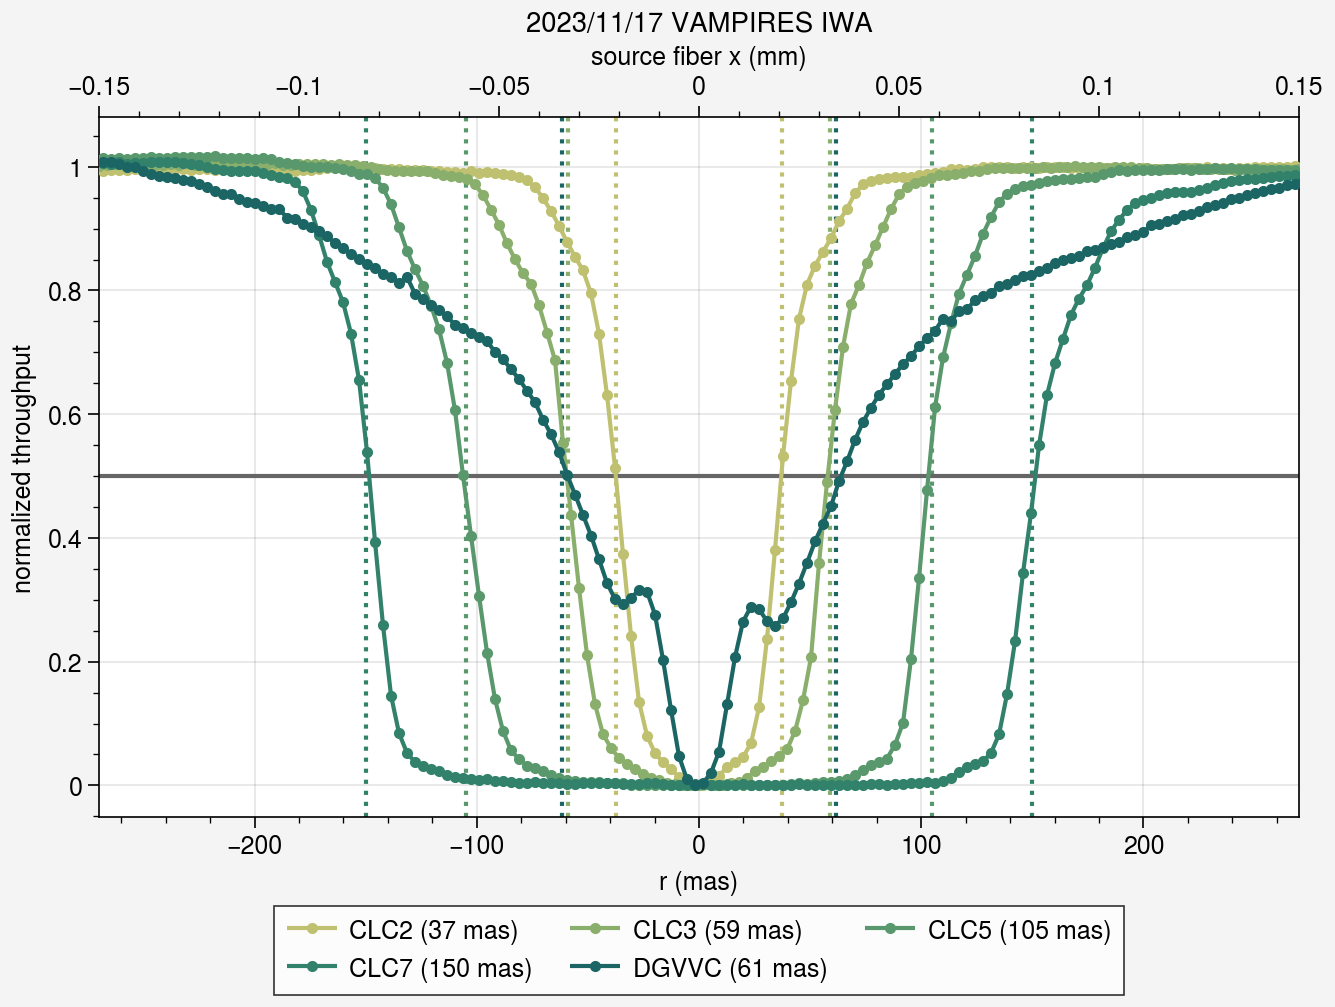

In [12]:
fig, axes = pro.subplots(refwidth="6in", refheight="3.5in")

for i, key in enumerate(fluxes):
    c = cycle[i]

    rad = radii

    axes[0].plot(
        radii[key] - centers[key],
        fluxes[key],
        marker=".",
        label=f"{key.upper()} ({iwas[key]:.0f} mas)",
        c=c,
        zorder=100 + i
    )
    axes[0].axvline(-iwas[key], c=c, ls=":")
    axes[0].axvline(iwas[key], c=c, ls=":")
legend = axes[0].legend(ncols=3, loc="bottom")
axes[0].axhline(0.5, c="0.4")
axes.format(
    grid=True,
    xlabel="r (mas)",
    ylabel="normalized throughput",
    xlim=(-270, 270)
)
axes[0].dualx(lambda x: x / plate_scale, label="source fiber x (mm)")
axes[0].format(title="2023/11/17 VAMPIRES IWA")
fig.savefig(figdir / "20231117_vampires_two_sided_iwa.pdf", dpi=300)

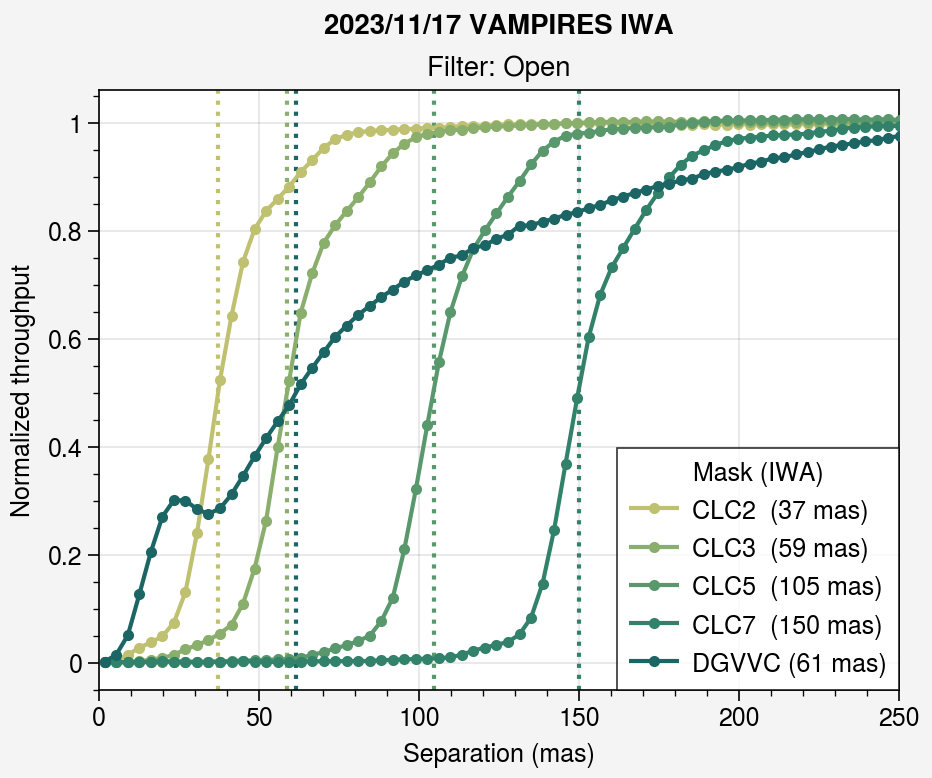

In [13]:
fig, axes = pro.subplots(refwidth="4in", refheight="3in")

for i, key in enumerate(fluxes):
    c = cycle[i]

    rad = radii[key] - centers[key]
    ave_flux = []
    ave_r= []
    pos = rad > 0
    neg = rad < 0
    for f1, f2, r1, r2 in zip(fluxes[key][pos], reversed(fluxes[key][neg]), rad[pos], reversed(rad[neg])):
        ave_flux.append(0.5 * (f1 + f2))
        ave_r.append(0.5 *(r1 - r2))

    rads = np.array(ave_r)
    average = np.array(ave_flux)

    axes[0].plot(
        rads,
        average,
        marker=".",
        label=f"{key.upper():5s} ({iwas[key]:.0f} mas)",
        c=c,
        zorder=100 + i
    )
    axes[0].axvline(iwas[key], c=c, ls=":")
legend = axes[0].legend(ncols=1, title="Mask (IWA)")
# axes[0].axhline(0.5, c="0.4")
axes.format(
    grid=True,
    xlabel="Separation (mas)",
    ylabel="Normalized throughput",
    xlim=(0, 250)
)
axes[0].format(title="Filter: Open")
fig.suptitle("2023/11/17 VAMPIRES IWA")
fig.savefig(figdir / "20231117_vampires_one_sided_iwa.pdf", dpi=300)